In [4]:
import sys
sys.path.append('..')
import h5py
import jax
import yaml
import matplotlib
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
plt.style.use('../flowrec/utils/a4.mplstyle')

from ml_collections import config_dict
from pathlib import Path
from scipy.interpolate import RBFInterpolator
from mpl_toolkits.axes_grid1 import ImageGrid

import flowrec.data as data_utils
import flowrec.physics_and_derivatives as derivatives
import flowrec.training_and_states as state_utils
from flowrec import losses
from flowrec.utils import simulation2d
from flowrec.utils.py_helper import slice_from_tuple

In [5]:
results_dir = Path('../local_results/draft/')
dt = 0.125 

In [6]:
## best runs measured by relative l2 with clean testing set
listsnr20 = ['snr20_classic/snr20_classic-41','snr20_3/snr20_3-6','snr20_mean3/snr20_mean3-41']
listsnr20 = [Path(results_dir,run) for run in listsnr20]
listsnr10 = ['snr10_classic/snr10_classic-278','snr10_3/snr10_3-278','snr10_mean3/snr10_mean3-6']
listsnr10 = [Path(results_dir,run) for run in listsnr10]
listsnr5 = ['snr5_classic/snr5_classic-278','snr5_3/snr5_3-41','snr5_mean3/snr5_mean3-278']
listsnr5 = [Path(results_dir,run) for run in listsnr5]

# Get results

In [7]:
def interpolate(u,pb,case_observe,datacfg):

    take_observation, insert_observation = case_observe(datacfg, example_pred_snapshot=u[0,...],example_pin_snapshot=pb[0,...])
    observed = take_observation(u)
    temp_observed = np.empty_like(u)
    temp_observed.fill(np.nan) #this is noisy
    temp_observed = insert_observation(jnp.asarray(temp_observed),jnp.asarray(observed)) # observed_test is noisy if

    # get sensor coordinates
    sensors_empty = np.empty_like(u[[0],...])
    sensors_empty.fill(np.nan)

    grid_x,grid_y = np.mgrid[0:u[...,0].shape[1], 0:u[...,0].shape[2]]

    gridx1 = np.repeat(grid_x[None,:,:,None],3,axis=3)
    gridy1 = np.repeat(grid_y[None,:,:,None],3,axis=3)

    idx_x = take_observation(gridx1)
    idx_y = take_observation(gridy1)

    idx_x = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_x))[0,...]
    sensors_loc_x = []
    for i in range(idx_x.shape[-1]):
        sensors_loc_x.append(idx_x[...,i][~np.isnan(idx_x[...,i])])

    idx_y = insert_observation(jnp.asarray(sensors_empty),jnp.asarray(idx_y))[0,...]
    sensors_loc_y = []
    for i in range(idx_y.shape[-1]):
        sensors_loc_y.append(idx_y[...,i][~np.isnan(idx_y[...,i])])


    compare_interp = list([])
    nt = u.shape[0]
    _locs = np.stack((grid_x.flatten(),grid_y.flatten()),axis=-1)

    for i in range(3):
        sensors_loc = np.stack((sensors_loc_x[i].flatten(),sensors_loc_y[i].flatten()),axis=-1)
        for j in range(nt):
            temp_measurement = temp_observed[j,...,i][~np.isnan(temp_observed[j,...,i])]
            # print(sensors_loc.shape, temp_measurement.shape)
            rbf = RBFInterpolator(sensors_loc,temp_measurement.flatten(),kernel='thin_plate_spline')
            _interp = rbf(_locs).reshape(grid_x.shape)
            compare_interp.append(_interp)
    compare_interp = np.array(compare_interp)
    compare_interp = np.stack((compare_interp[:nt,...],compare_interp[nt:2*nt,...],compare_interp[2*nt:3*nt,...]),axis=-1)

    return compare_interp

In [8]:
def get_single_case_predictions(folder):
    with open(Path(folder,'config.yml'),'r') as f:
        cfg = yaml.load(f, Loader=yaml.UnsafeLoader)
        cfg.data_config.data_dir = '.'+cfg.data_config.data_dir
        rng = np.random.default_rng(cfg.data_config.randseed)

    x_base = 132
    triangle_base_coords = [49,80]
    (ux,uy,pp) = simulation2d.read_data(cfg.data_config.data_dir,x_base)
    x = np.stack([ux,uy,pp],axis=0)
    # remove parts where uz is not zero
    s = slice_from_tuple(cfg.data_config.slice_to_keep)
    x = x[s]

    [_,_,x_test], _ = data_utils.data_partition(x,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss

    [ux_test,uy_test,pp_test] = np.squeeze(np.split(x_test,3,axis=0))

    datainfo = data_utils.DataMetadata(
        re = cfg.data_config.re,
        discretisation=[cfg.data_config.dt,cfg.data_config.dx,cfg.data_config.dy],
        axis_index=[0,1,2],
        problem_2d=True
    ).to_named_tuple()

    u_test = np.stack((ux_test,uy_test,pp_test),axis=-1)

    std_data = np.std(x,axis=(1,2,3),ddof=1)
    std_n = data_utils.get_whitenoise_std(cfg.data_config.snr,std_data)
    noise_ux = rng.normal(scale=std_n[0],size=x[0,...].shape)
    noise_uy = rng.normal(scale=std_n[1],size=x[1,...].shape)
    noise_pp = rng.normal(scale=std_n[2],size=x[2,...].shape)
    noise = np.stack([noise_ux,noise_uy,noise_pp],axis=0)
    x_noisy = x + noise

    [_,_,x_test_n], _ = data_utils.data_partition(x_noisy,
        1,
        cfg.data_config.train_test_split,
        REMOVE_MEAN=cfg.data_config.remove_mean,
        randseed=cfg.data_config.randseed,
        SHUFFLE=cfg.data_config.shuffle
    ) # Do not shuffle, do not remove mean for training with physics informed loss
    [ux_test_n,uy_test_n,pp_test_n] = np.squeeze(np.split(x_test_n,3,axis=0))

    ## normalise
    if cfg.data_config.normalise:
        [ux_test_normal_n,uy_test_normal_n,pp_test_normal_n], test_minmax = data_utils.normalise(ux_test_n,uy_test_n,pp_test_n)
        ## take input
        pb_test = simulation2d.take_measurement_base(pp_test_normal_n,ly=triangle_base_coords,centrex=0)
    else:
        ## take input
        pb_test = simulation2d.take_measurement_base(pp_test_n,ly=triangle_base_coords,centrex=0)

    pb_test = np.reshape(pb_test,(cfg.data_config.train_test_split[2],-1))
    u_test_n = np.stack((ux_test_n,uy_test_n,pp_test_n),axis=-1)
    
    
    ## predict
    state = state_utils.restore_trainingstate(folder,'state')
    _, make_model = cfg.case.select_model(datacfg=cfg.data_config, mdlcfg=cfg.model_config, traincfg=cfg.train_config)
    mdl = make_model(cfg.model_config)
    rng_mdl = jax.random.PRNGKey(cfg.train_config.randseed)
    pred_test = mdl.apply(state.params,rng_mdl,pb_test,TRAINING=False)
    if cfg.data_config.normalise:
        pred_test = data_utils.unnormalise_group(pred_test, test_minmax, axis_data=-1, axis_range=0)

    interp_test = interpolate(u_test_n,pb_test,cfg.case.observe,cfg.data_config)

    return (u_test, u_test_n, interp_test, pred_test), datainfo

In [9]:
def get_same_snr_prediction(folder_list):
    
    results = []

    (u_test, u_test_n, interp_test, pred_test),datainfo = get_single_case_predictions(folder_list[0])

    results.append(u_test)
    results.append(interp_test)
    results.append(pred_test) # classic

    for folder in folder_list[1:]:
        (_,_,_,pred_test),_ = get_single_case_predictions(folder)
        results.append(pred_test)
    
    results.append(u_test_n)

    return results, datainfo #[true, interp, classic, 3, mean3, noisy]

In [11]:
results20, datainfo20 = get_same_snr_prediction(listsnr20)
print('1')
results10, datainfo10 = get_same_snr_prediction(listsnr10)
print('2')
results5, datainfo5 = get_same_snr_prediction(listsnr5)

1
2


# Make figures

### Instantaneous and mean images

In [12]:
def make_image_imshow(data,figname,t):
    labels = ['True','Interpolated','$\mathcal{L}^c$','$\mathcal{L}^s$','$\mathcal{L}^m$']

    fig = plt.figure(figsize=(7,4))
    gridtop = ImageGrid(fig,(0.05,0.49,0.85,0.4),(1,5),share_all=True,cbar_mode='single',cbar_pad=0.01)
    for i,(ax,cax) in enumerate(zip(gridtop.axes_all,gridtop.cbar_axes)):
        im = ax.imshow(data[i][t,...,0],extent=[-2,2,5.86,0])
        ax.set_title(labels[i],pad=15)
        if i == 0:
            cax.colorbar(im,label='$u_1$')
            ax.set(xticks=[], yticks=[])

    gridbo = ImageGrid(fig,(0.05,0.06,0.85,0.4),(1,5),share_all=True,cbar_mode='single',cbar_pad=0.01)
    for i,(ax,cax) in enumerate(zip(gridbo.axes_all,gridbo.cbar_axes)):
        im = ax.imshow(np.mean(data[i][...,0],axis=0),extent=[-2,2,5.86,0])
        if i == 0:
            cax.colorbar(im,label='$u_1$')
            ax.set(xlabel='$x_2$', ylabel='$x_1$', xticks=[], yticks=[])


    fig.text(0.01,0.6,f'$t={t*dt}$',rotation='vertical',fontsize='large')
    fig.text(0.01,0.25,f'Mean',rotation='vertical',fontsize='large')

    fig.savefig('./figs/'+figname,bbox_inches='tight')

/tmp/ipykernel_22629/435368098.py:24: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig('./figs/'+figname,bbox_inches='tight')
/tmp/ipykernel_22629/435368098.py:24: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.savefig('./figs/'+figname,bbox_inches='tight')
/home/ym917/anaconda3/envs/fr/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/ym917/anaconda3/envs/fr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


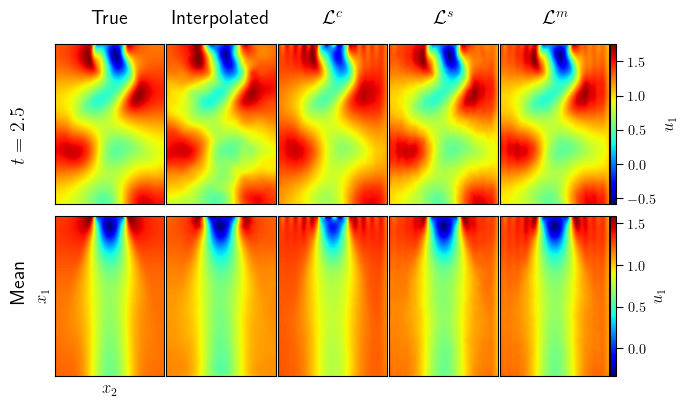

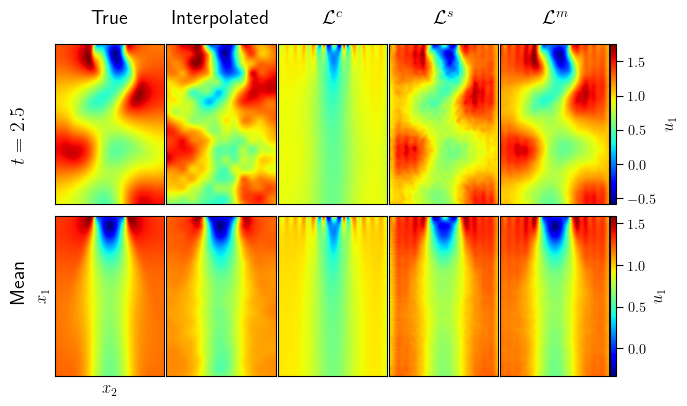

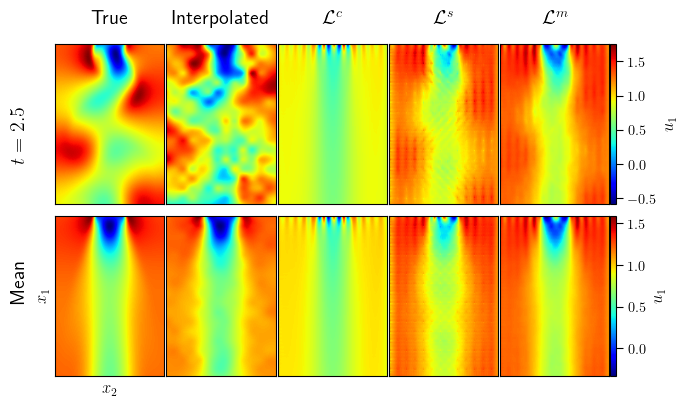

In [13]:
make_image_imshow(results20,'snr20_images',20)
make_image_imshow(results10,'snr10_images',20)
make_image_imshow(results5,'snr5_images',20)


### probability density

In [14]:
def make_image_pdf(data,figname):

    ## interpolation
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[1][0,...,i])
        interp_test_nonan.append(data[1][...,i][:,mask])

    ## plot
    fig,axes = plt.subplots(1,3)
    for i,var in zip(range(3),['$u_1^\prime$','$u_2^\prime$','$p^\prime$']):
        # true
        counts_true,bins_true = np.histogram(data[0][...,i].flatten()-np.mean(data[0][...,i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts_true,bins_true,label='True',linewidth=3, color='#808080',alpha=0.5)
        # interpolation
        counts,bins = np.histogram(interp_test_nonan[i].flatten()-np.mean(interp_test_nonan[i].flatten()), density=True, bins='auto')
        axes[i].stairs(counts,bins,label='Interp.',color='k',linestyle='--')
        
        # prediction
        for j,lossfn in zip([2,3,4],['$\mathcal{L}^c$','$\mathcal{L}^s$','$\mathcal{L}^m$']):
            counts,bins = np.histogram(data[j][...,i].flatten()-np.mean(data[j][...,i].flatten()), density=True, bins='auto')
            axes[i].stairs(counts,bins,label=lossfn)
        axes[i].set(xlabel=var)
    axes[0].set_ylabel('Probability density')

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncols=5)

    plt.savefig('./figs/'+figname,bbox_inches='tight')
    # plt.show()


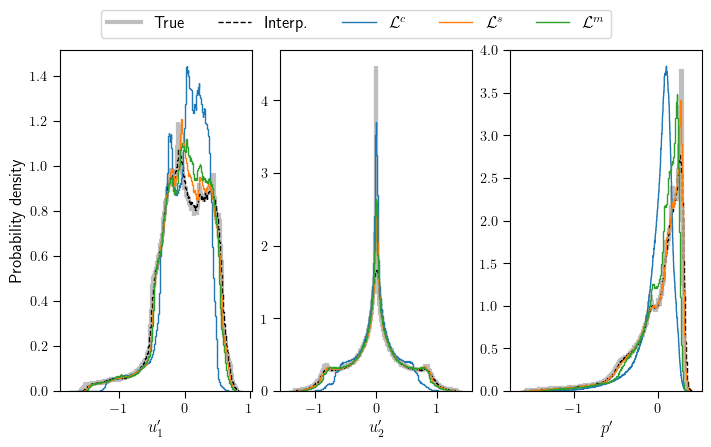

In [15]:
make_image_pdf(results20,'snr20_pdf')

In [16]:
def make_image_pdf_separate_classic(data,figname):
    ## interpolation
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[1][0,...,i])
        interp_test_nonan.append(data[1][...,i][:,mask])

    fig,axes = plt.subplots(2,3,height_ratios=(0.3,1))
    axesb = axes[1,:]
    axest = axes[0,:]

    var_names = ['$u_1^\prime$','$u_2^\prime$','$p^\prime$']
    
    for i in range(3):
        counts,bins = np.histogram(data[2][...,i].flatten()-np.mean(data[2][...,i].flatten()), density=True, bins='auto')
        axest[i].stairs(counts,bins,label='$\mathcal{L}^c$')
        counts_true,bins_true = np.histogram(data[0][...,i].flatten()-np.mean(data[0][...,i].flatten()), density=True, bins='auto')
        axest[i].stairs(counts_true,bins_true,label='True',linewidth=3, color='#808080',alpha=0.5)
    
        counts_true,bins_true = np.histogram(data[0][...,i].flatten()-np.mean(data[0][...,i].flatten()), density=True, bins='auto')
        axesb[i].stairs(counts_true,bins_true,label='True',linewidth=3, color='#808080',alpha=0.5)
        # interpolation
        counts,bins = np.histogram(interp_test_nonan[i].flatten()-np.mean(interp_test_nonan[i].flatten()), density=True, bins='auto')
        axesb[i].stairs(counts,bins,label='Interp.',color='k',linestyle='--')
        
        # prediction
        for j,lossfn,c in zip([3,4],['$\mathcal{L}^s$','$\mathcal{L}^m$'],['tab:orange','tab:green']):
            counts,bins = np.histogram(data[j][...,i].flatten()-np.mean(data[j][...,i].flatten()), density=True, bins='auto')
            axesb[i].stairs(counts,bins,label=lossfn,color=c)
        axesb[i].set(xlabel=var_names[i])


    axest[0].set_ylabel('Probability density')
    axesb[0].set_ylabel('Probability density')
    tmphandler,templabel = axest[0].get_legend_handles_labels()
    h_data = tmphandler[1]
    l_data = templabel[1]
    h_c = tmphandler[0]
    l_c = templabel[0]
    tmphandler,templabel = axesb[0].get_legend_handles_labels()
    h_interp = tmphandler[1]
    l_interp = templabel[1]
    h_loss = tmphandler[2:]
    l_loss = templabel[2:]

    handlers = [h_data,h_interp,h_c,*h_loss]
    label = [l_data,l_interp,l_c,*l_loss]
    fig.legend(handlers,label,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncols=5)
    plt.savefig('./figs/'+figname,bbox_inches='tight')

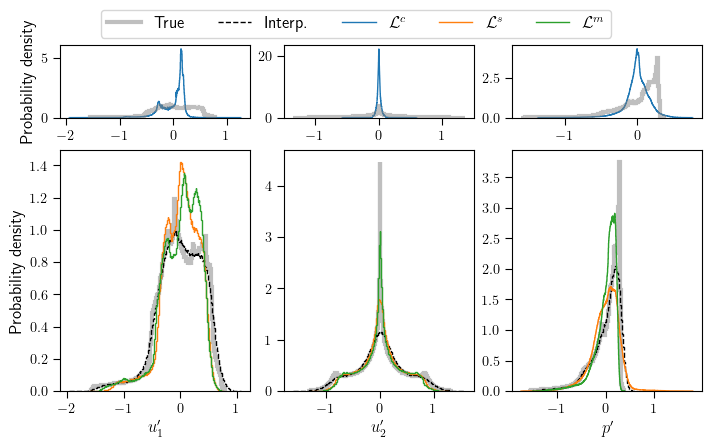

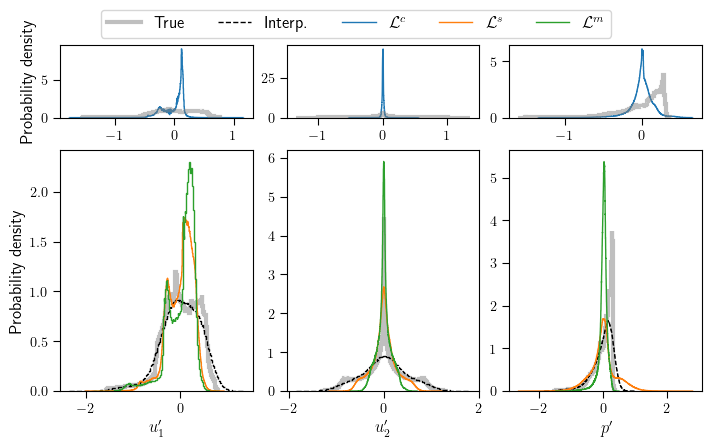

In [17]:
make_image_pdf_separate_classic(results10,'snr10_pdf')
make_image_pdf_separate_classic(results5,'snr5_pdf')

### Frequency spectrum

In [18]:
var_names = ['$u_1^\prime$','$u_2^\prime$','$p^\prime$']

def make_image_freq(data, figname):

    n = np.prod(data[0].shape[1:-1])

    fftfreq = np.fft.fftfreq(data[0].shape[0],d = dt)
    midpoint = int(len(fftfreq)/2)
    
    # data
    f_data = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[0]-np.mean(data[0],axis=0),axis=0)))

    # interpolated
    interp_test_nonan = []
    for i in range(3):
        mask = ~np.isnan(data[1][0,...,i])
        interp_test_nonan.append(data[1][...,i][:,mask])
    f_interp = []
    for i in range(3):
        _interp = np.einsum('t n -> t', np.abs(np.fft.fft(interp_test_nonan[i]-np.mean(interp_test_nonan[i]),axis=0)))
        # _interp = _interp / np.std(_interp)
        f_interp.append(_interp)


    fig, axes = plt.subplots(1,3,sharex=True,figsize=(7,3.5))
    for i in range(3):
        axes[i].plot(fftfreq[:midpoint], 2*f_data[:midpoint,i],label='True',linewidth=3,color='#808080',alpha=0.5)
        axes[i].plot(fftfreq[:midpoint], 2*f_interp[i][:midpoint],label='Interp',linewidth=1,color='k',linestyle='--')
        
        for j,lossfn,c in zip([2,3,4],['$\mathcal{L}^c$','$\mathcal{L}^s$','$\mathcal{L}^m$'],['tab:blue','tab:orange','tab:green']):
            f_pred = np.einsum('t x y u -> t u', np.abs(np.fft.fft(data[j]-np.mean(data[j],axis=0),axis=0)))
            axes[i].plot(fftfreq[:midpoint], 2*f_pred[:midpoint,i],label=lossfn,linewidth=1,color=c)
        axes[i].set(xlabel='$Hz$',title=var_names[i])
        
    axes[0].set(ylabel='Magnitude', xlim=[0,4])
        

    handlers = axes[0].get_legend_handles_labels()
    fig.legend(*handlers,loc='upper center', bbox_to_anchor=(0.5, 1.1),ncols=5)
    plt.savefig('./figs/'+figname,bbox_inches='tight')

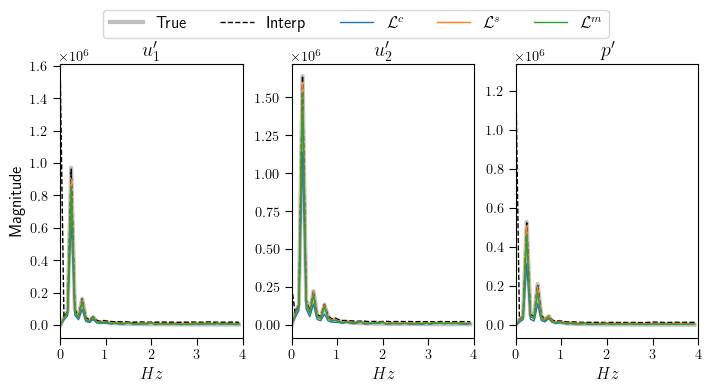

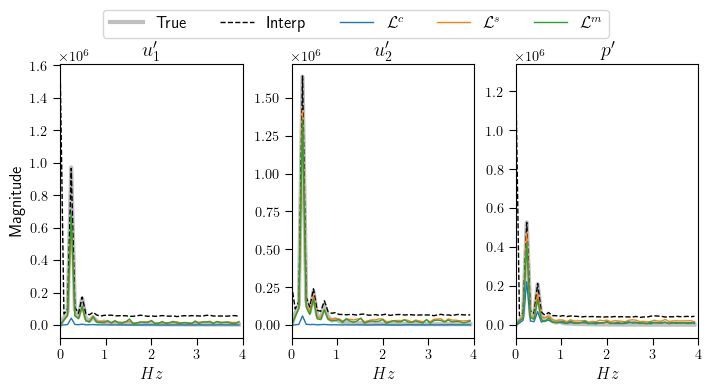

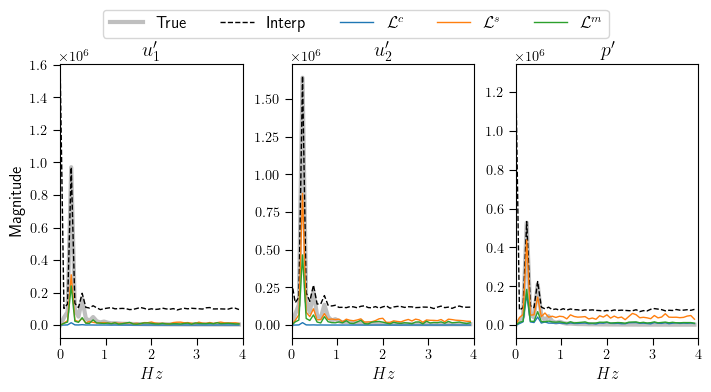

In [19]:
make_image_freq(results20,'snr20_freq')
make_image_freq(results10,'snr10_freq')
make_image_freq(results5,'snr5_freq')

# Print losses

In [20]:
def get_losses(data,datainfo):
    
    rel_loss = []
    
    rel_loss.append(0)
    mse_interp = np.sqrt(np.sum(np.nan_to_num(data[1] - data[0])**2)/ np.sum(data[0]**2))
    rel_loss.append(mse_interp)
    
    for i in range(2,5):
        rel_loss.append(losses.relative_error(data[i],data[0]))

    loss_physics=[]
    
    for i in range(5):
        if i == 1:
            l_d = losses.divergence(np.nan_to_num(data[i])[...,:-1],datainfo=datainfo)
            l_m = losses.momemtum_loss(np.nan_to_num(data[i]),datainfo=datainfo)
            loss_physics.append(float(l_d+l_m))
        else:
            l_d = losses.divergence(data[i][...,:-1],datainfo=datainfo)
            l_m = losses.momemtum_loss(data[i],datainfo=datainfo)
            loss_physics.append(float(l_d+l_m))

    print('         True         interp          classic         3          mean3')
    print(f'Rel l2: {rel_loss}')
    print(f'L_p: {loss_physics}')

In [21]:
get_losses(results20,datainfo20)
get_losses(results10,datainfo10)
get_losses(results5,datainfo5)

         True         interp          classic         3          mean3
Rel l2: [0, 0.05528874992371944, 0.1903976, 0.062761165, 0.0653128]
L_p: [0.026258869096636772, 0.3170250356197357, 0.0396430529654026, 0.1430346965789795, 0.049280859529972076]
         True         interp          classic         3          mean3
Rel l2: [0, 0.14601513050274098, 0.5163785, 0.26075423, 0.13494654]
L_p: [0.026258869096636772, 2.546692371368408, 0.0241777915507555, 0.9425448179244995, 0.2384735345840454]
         True         interp          classic         3          mean3
Rel l2: [0, 0.2553046945617001, 0.54538363, 0.61650574, 0.38216093]
L_p: [0.026258869096636772, 7.987826824188232, 0.04605870321393013, 2.4331729412078857, 0.17925958335399628]
